1. 爬取雾霾数据
2. 研究雾霾在最近5年的变化趋势
3. 研究雾霾和风向、风力的关系

### 爬取雾霾数据

雾霾数据网站：https://www.aqistudy.cn/historydata/
1. scrapy startproject aqi
2. cd aqi, scrapy genspider myaqi www.aqistudy.cn
3. 编写item.py
4. 编写spider主体程序，myaqi.py
5. 编写中间件middleware.py
6. 修改setting.py
7. scrapy crawl myaqi -o aqi.csv

注意：需要pip install selenium 并下载谷歌浏览器对应版本的驱动chromedriver.exe， 放在已经加入到系统环境变量的python对应的路径里，例如：E:\Users\kong\Anaconda3\Library\bin

In [246]:
#item.py
import scrapy
class AqiItem(scrapy.Item):
    # define the fields for your item here like:
    # name = scrapy.Field()
    city = scrapy.Field()
    date = scrapy.Field()
    AQI = scrapy.Field()
    qLevel = scrapy.Field()
    PM25 = scrapy.Field()


In [ ]:
#myaqi.py

# -*- coding: utf-8 -*-
import scrapy
from aqi.items import AqiItem
import pandas as pd


class MyaqiSpider(scrapy.Spider):
    name = 'myaqi'
    allowed_domains = ['www.aqistudy.cn']
    base_url = 'https://www.aqistudy.cn/historydata/'
    start_urls = ['https://www.aqistudy.cn/historydata/daydata.php?city=北京&month=201402']
    cities = ['北京']
    Dates = pd.date_range(start='1/2014', end='9/2019', freq='M')

    def parse(self, response):
        URLs = []
        for city in self.cities:
            for date in self.Dates:
                url = self.base_url + "daydata.php?city=" + city + "&month=" + date.strftime("%Y%m")
                URLs.append(url)
        for url in URLs:
            yield scrapy.Request(url,callback = self.parse_data,meta={"city":city,'source':url})


    def parse_data(self, response):
        node_list = response.xpath('//tbody/tr')
        n0 = node_list.pop(0)

        for node in node_list:
            item = AqiItem()
            item['city'] = '北京'
            item['date'] = node.xpath('./td[1]//text()').get()
            item['AQI'] = node.xpath('./td[2]//text()').get()
            item['qLevel'] = node.xpath('./td[3]//text()').get()
            item['PM25'] = node.xpath('./td[4]//text()').get()
            yield item


In [ ]:
#middlewares.py
import scrapy
from scrapy import signals
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
import time

#在 middlewares.py中AqiSpiderMiddleware类里找到process_request函数，修改为：
    def process_request(self, request, spider):
        chrome_options = Options()
        chrome_options.add_argument('--headless')  # 使用无头谷歌浏览器模式
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--no-sandbox')
        # 指定谷歌浏览器路径
        self.driver = webdriver.Chrome(chrome_options=chrome_options)
        if request.url != 'https://www.aqistudy.cn/historydata/':
            self.driver.get(request.url)
            time.sleep(1)
            html = self.driver.page_source
            self.driver.quit()
            return scrapy.http.HtmlResponse(url=request.url, body=html.encode('utf-8'), encoding='utf-8',
                                            request=request)

In [ ]:
#setting.py
import scrapy_fake_useragent
LOG_LEVEL = 'ERROR'
DOWNLOADER_MIDDLEWARES = {
'aqi.middlewares.AqiDownloaderMiddleware': 543,
'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware':None,# 关闭默认方法
'scrapy_fake_useragent.middleware.RandomUserAgentMiddleware':400,# 开启
}

风速风向网站：https://lishi.tianqi.com/beijing/201908.html
1. scrapy startproject weather
2. cd weather, scrapy genspider weatherspider example.com
3. 编写item.py
4. 编写spider主体程序，weatherspider.py
5. 修改setting.py，设置agent
6. scrapy crawl weatherspider -o weather_beijing.csv

In [ ]:
#items.py
import scrapy
class WeatherItem(scrapy.Item):
    # define the fields for your item here like:
    # 日期
    date = scrapy.Field()
    # 风向
    windDirec = scrapy.Field()
    # 风力
    windLevel = scrapy.Field()
    # 数据源
    source = scrapy.Field()


In [ ]:
#weatherspider.py
# -*- coding: utf-8 -*-
import scrapy
from weather.items import WeatherItem
import pandas as pd

class WeatherspiderSpider(scrapy.Spider):
    name = 'weatherspider'
    #allowed_domains = ['example.com']
    base_url = 'https://lishi.tianqi.com/'
    start_urls = [base_url]
    #cities  = ['beijing','shanghai','tianjin','chongqin','zhengzhou']
    cities = ['beijing']
    Dates = pd.date_range(start='1/2014',end='9/2019', freq='M')

    def parse(self, response):
        URLs = []
        for city in self.cities:
            for date in self.Dates:
                url = self.base_url + city+'/'+date.strftime("%Y%m")+'.html'
                URLs.append(url)
        for url in URLs:
            yield scrapy.Request(url,callback = self.parse_data,meta={"city":city,'source':url})

    def parse_data(self,response):
        node_list = response.xpath('//div[@class="tqtongji2"]/ul')
        n0 = node_list.pop(0)
        for node in node_list:
            #print (node)
            item = WeatherItem()
            item['date'] = node.xpath('./li[1]/a/text()').extract_first()
            item['windDirec'] = node.xpath('./li[5]/text()').extract_first()
            item['windLevel'] = node.xpath('./li[6]/text()').extract_first()
            item['source'] = response.meta['source']
            yield item

In [247]:
#setting.py
LOG_LEVEL = 'ERROR'
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:69.0) Gecko/20100101 Firefox/69.0'

### 数据分析

In [248]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置加载的字体名
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [26]:
#雾霾数据
aqi = pd.read_csv('aqi.csv')
aqi['date'] = pd.to_datetime(aqi.date,format = "%Y-%m-%d") #将date转换成datetime格式
aqi = aqi.sort_values(by = 'date')
#天气数据
weather = pd.read_csv('weather_beijing.csv')
weather['date'] = pd.to_datetime(weather.date,format = "%Y-%m-%d")
weather = weather.sort_values(by = 'date')

In [107]:
aqi.head()

,AQI,PM25,city,date,qLevel
552,81,45,北京,2014-01-01,良
553,145,111,北京,2014-01-02,轻度污染
554,74,47,北京,2014-01-03,良
555,149,114,北京,2014-01-04,轻度污染
556,119,91,北京,2014-01-05,轻度污染


### 研究雾霾在最近5年的变化趋势

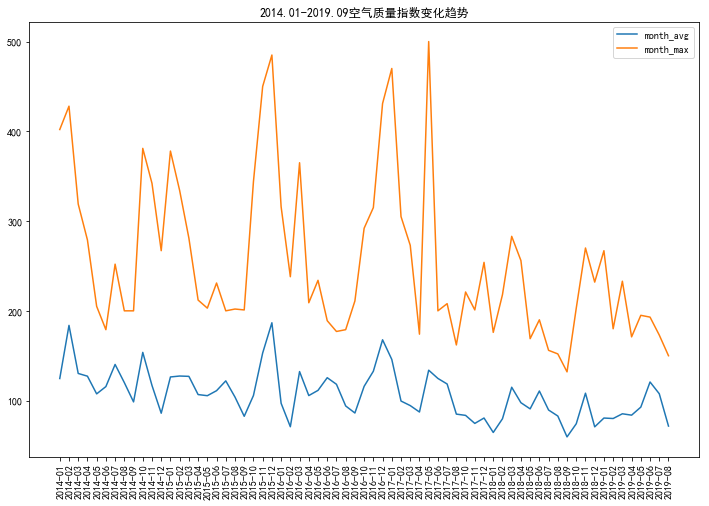

In [106]:
#画出每个月平均、以及最大值的aqi随时间的变化趋势
months = pd.date_range(start='2014-01',end='2019-09',freq = 'M')
month_names = []
month_avgaqi = []
month_maxaqi = []
for i in range(len(months)):
    if i == 0:
        data = aqi[aqi.date <= months[i]]
    else:
        data = aqi[(aqi.date > months[i-1]) & (aqi.date <= months[i])]
    if  data.shape[0] == 0:
        continue
    month_names.append(str(months[i])[0:7])
    month_avgaqi.append(np.mean(data.AQI.values))
    month_maxaqi.append(np.max(data.AQI.values))
plt.rcParams['figure.figsize'] = (12, 8) # 设置figure_size尺寸
x = [i for i in range(len(month_names))]
plt.plot(x,month_avgaqi,label = 'month_avg')
plt.plot(x,month_maxaqi,label = 'month_max')
plt.xticks(x,month_names,rotation=90)
plt.title('2014.01-2019.09空气质量指数变化趋势')
plt.legend()
plt.show()


从上图可以看出，空气质量指数整体呈下降趋势。对于每一年来说，每年的秋冬季（集中在10月-次年2月）AQI值较高，空气质量较差。

In [111]:
#画出每年各个污染等级的占比饼图。
uniq_levels = np.unique(aqi.qLevel)
print(uniq_levels)

['严重污染' '中度污染' '优' '无' '良' '轻度污染' '重度污染']


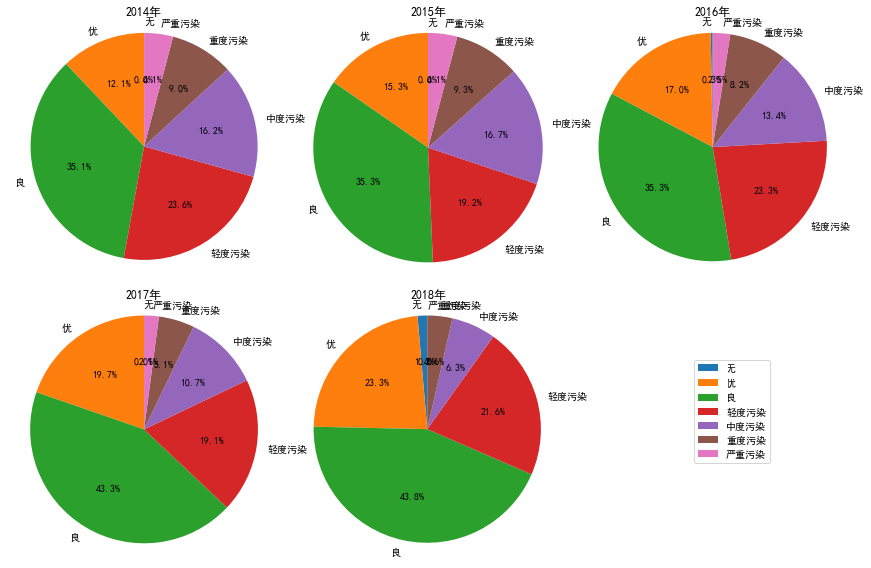

In [158]:
levels = ['无','优', '良', '轻度污染','中度污染','重度污染','严重污染']
years = pd.date_range(start='2014-01',end='2020-01',freq = 'Y')
res_year = {}
for i in range(len(years)):
    res_year[str(years[i])[0:4]] = []
    if i == 0:
        data = aqi[aqi.date <= years[i]]
    else:
        data = aqi[(aqi.date > years[i-1]) & (aqi.date <= years[i])]
    if data.shape[0] == 0:
        continue
    for level in levels:
        data_level = data[data.qLevel == level]
        res_year[str(years[i])[0:4]].append(len(data_level))

fig1 = plt.subplot(231)
plt.pie(res_year['2014'],labels=levels,autopct='%1.1f%%',shadow=False,startangle=90)
plt.axis('equal')
plt.title("2014年")

fig2 = plt.subplot(232)
plt.pie(res_year['2015'],labels=levels,autopct='%1.1f%%',shadow=False,startangle=90)
plt.axis('equal')
plt.title("2015年")

fig3 = pl.subplot(233)
plt.pie(res_year['2016'],labels=levels,autopct='%1.1f%%',shadow=False,startangle=90)
plt.axis('equal')
plt.title("2016年")


fig4 = pl.subplot(234)
plt.pie(res_year['2017'],labels=levels,autopct='%1.1f%%',shadow=False,startangle=90)
plt.axis('equal')
plt.title("2017年")

fig5 = pl.subplot(235)
plt.pie(res_year['2018'],labels=levels,autopct='%1.1f%%',shadow=False,startangle=90)#startangle表示饼图的起始角度
plt.axis('equal') #这行代码加入饼图不会画成椭圆
plt.title("2018年")

plt.legend(bbox_to_anchor=(1.8,0.8))
plt.tight_layout() #布局方法
pl.show() #显示方法


从上图可以看出，空气质量状况逐年好转，污染天数占比逐年减少，严重污染天数到2018年几乎为0。

### 研究雾霾和风向、风力的关系

In [211]:
data = pd.merge(aqi,weather,on = 'date',how = 'inner')
print(np.unique(data.windDirec))
print(np.unique(data.windLevel))
print(data.shape)
data.head()

['东北风' '东北风~微风' '东南风' '东风' '北风' '北风~南风' '北风~微风' '南风' '南风~北风' '南风~微风' '微风'
 '微风~东北风' '微风~北风' '微风~南风' '无持续风向' '西北风' '西南风' '西风' '西风~微风']
['1级' '2级' '3-4级' '3-4级~4-5级' '3-4级~5-6级' '3-4级~小于3级' '3级' '4-5级'
 '4-5级~3-4级' '4-5级~5-6级' '4-5级~小于3级' '4级' '4～5级' '5-6级' '5-6级~3-4级'
 '5-6级~4-5级' '5级' '6-7级~4-5级' '6级' '7级' '小于3级' '小于3级~3-4级' '小于3级~4-5级'
 '小于3级~5-6级' '小于3级~6-7级' '微风']
(2032, 8)


,AQI,PM25,city,date,qLevel,source,windDirec,windLevel
0,81,45,北京,2014-01-01,良,https://lishi.tianqi.com/beijing/201401.html,微风,小于3级
1,145,111,北京,2014-01-02,轻度污染,https://lishi.tianqi.com/beijing/201401.html,微风,小于3级
2,74,47,北京,2014-01-03,良,https://lishi.tianqi.com/beijing/201401.html,微风,小于3级
3,149,114,北京,2014-01-04,轻度污染,https://lishi.tianqi.com/beijing/201401.html,微风,小于3级
4,119,91,北京,2014-01-05,轻度污染,https://lishi.tianqi.com/beijing/201401.html,微风,小于3级


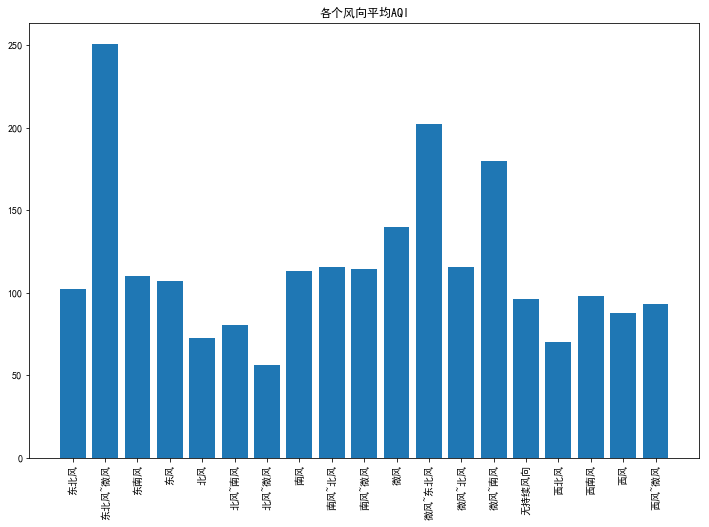

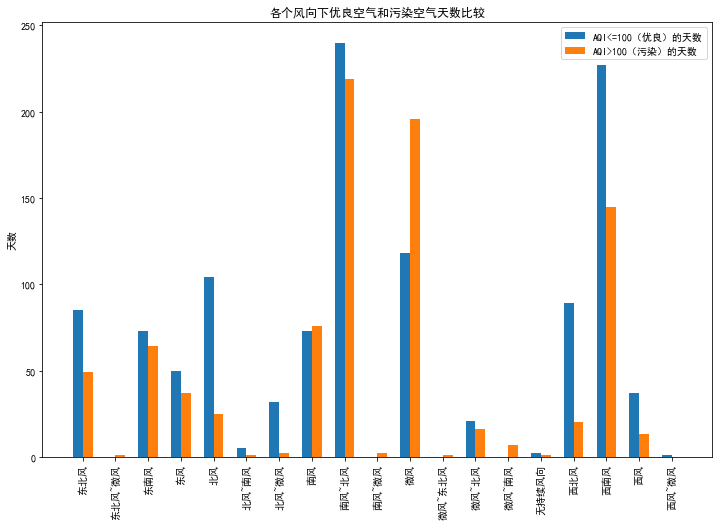

In [245]:
#分析雾霾和风向的关系，统计每种风向里空气质量优良（AQI<=100），以及污染(AQI>100)天数的变化，以及平均AQI的变化
#平均AQI
avg_direc = []
direc_names = list(np.unique(data.windDirec))
for direc in direc_names:
    avg_direc.append(np.mean(data['AQI'][data.windDirec == direc]))
x = [i for i in range(len(avg_direc))]
plt.figure(1)
plt.bar(x,avg_direc)
plt.xticks(x,direc_names,rotation=90)
plt.title('各个风向平均AQI')
plt.show()

#每种风向里空气质量优良（AQI<=100），以及污染(AQI>100)天数所占百分比
aqi_good = []
aqi_bad = []
for direc in direc_names:
    aqi_good.append(len(data[(data.AQI<=100) & (data.windDirec == direc)]))
    aqi_bad.append(len(data[(data.AQI>100) & (data.windDirec == direc)]))
    
plt.figure(2) 
#词频的柱状图
total_width, n = 0.6, 2
width = total_width / n
x = np.arange(len(direc_names))
plt.bar(x, aqi_good, width=width, label='AQI<=100（优良）的天数')  
plt.bar(x+width, aqi_bad, width=width, label='AQI>100（污染）的天数')
plt.xticks(x+width/2,direc_names,rotation=90 )#显示x坐标轴的标签,调整位置，使其落在两个直方图中间位置
plt.legend()
plt.title('各个风向下优良空气和污染空气天数比较')
plt.ylabel("天数")
plt.show()


从图1可以看出“东北风~微风”、“微风~东北风”、“微风~南风”AQI指数较高，空气质量较差；“北风~微风”、“北风”、“西北风”AQI指数较低，空气质量较好。结合图2，微风空气污染的天数较多，不利于雾霾扩散。

['0~1级风', '1~2级风', '2~3级风', '3~4级风', '4~5级风', '5~6级风', '6~7级风', '7~8级风']


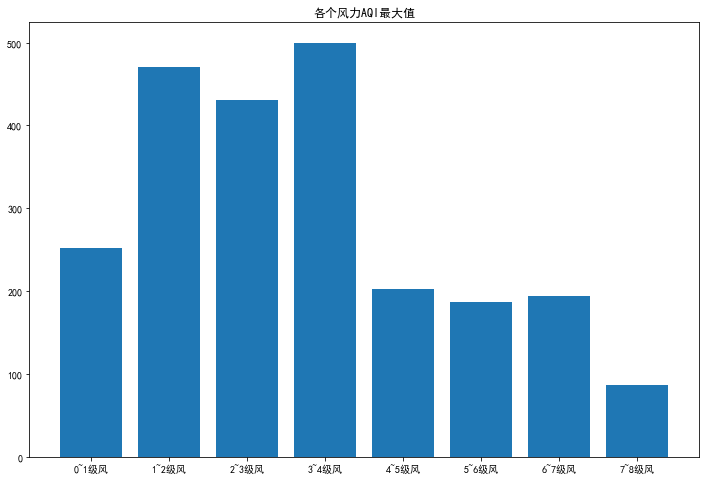

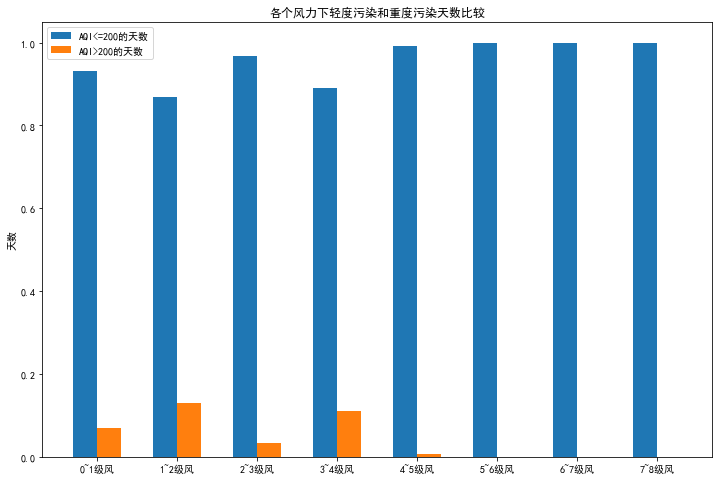

In [243]:
#分析雾霾和风力的关系，为简单起见把风力区间去平均值，映射到一个实数上。范围是0-7
level_names = np.unique(data.windLevel)
wind_level_dict = {}
wind_levels = []
for l in level_names:
    if l == '微风':
        tmp = 0
    else:
        tmp = int(np.mean([int(i) for i in re.findall('(\d+)',l)]))
    wind_levels.append("%s~%s级风"%(tmp,tmp+1))
    wind_level_dict[l] = "%s~%s级风"%(tmp,tmp+1)
wind_levels = sorted(set(wind_levels))
print(wind_levels)
data_new = data.copy()
for name in level_names:
    data_new['windLevel'].replace(name,wind_level_dict[name],inplace = True)
    
#类似和风向的关系，分析平均AQI以及污染天数的变化
#最大AQI
max_speed = []
for speed in wind_levels:
    max_speed.append(max(data['AQI'][data_new.windLevel == speed]))
x = [i for i in range(len(max_speed))]
plt.figure(1)
plt.bar(x,max_speed)
plt.xticks(x,wind_levels)
plt.title('各个风力AQI最大值')
plt.show()

#每种风速里空气质量中度污染（AQI<=200），以及重度污染(AQI>200)天数所占百分比
aqi_good = []
aqi_bad = []
for speed in wind_levels:
    aqi_good.append(len(data_new[(data_new.AQI<=200) & (data_new.windLevel == speed)])/ len(data[data_new.windLevel == speed]))
    aqi_bad.append(len(data_new[(data_new.AQI>200) & (data_new.windLevel == speed)])/ len(data[data_new.windLevel == speed]))
    
plt.figure(2) 
#词频的柱状图
total_width, n = 0.6, 2
width = total_width / n
x = np.arange(len(wind_levels))
plt.bar(x, aqi_good, width=width, label='AQI<=200的天数') 
plt.bar(x+width, aqi_bad, width=width, label='AQI>200的天数')
plt.xticks(x+width/2,wind_levels )#显示x坐标轴的标签,调整位置，使其落在两个直方图中间位置
plt.legend()
plt.title('各个风力下轻度污染和重度污染天数比较')
plt.ylabel("天数")
plt.show()

从上图可以看出，风速越大可以减少重度污染的天气情况，如图1，风力在4级以上时，AQI最大值明显降低。图2分析了AQI<=200和AQI>200的污染天数对比，风力在5级以上时没有重度污染（AQI>200）的情况，可见风速越大越有利于雾霾消散。